In [40]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow import keras
import PIL
import os
import cv2
import pathlib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [66]:
tf.keras.backend.clear_session()

In [42]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is ready")
    except RuntimeError as e:
        print(e)


GPU is ready


In [43]:
feature_prediction = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=(224, 224, 3))
])

In [44]:
feature_prediction

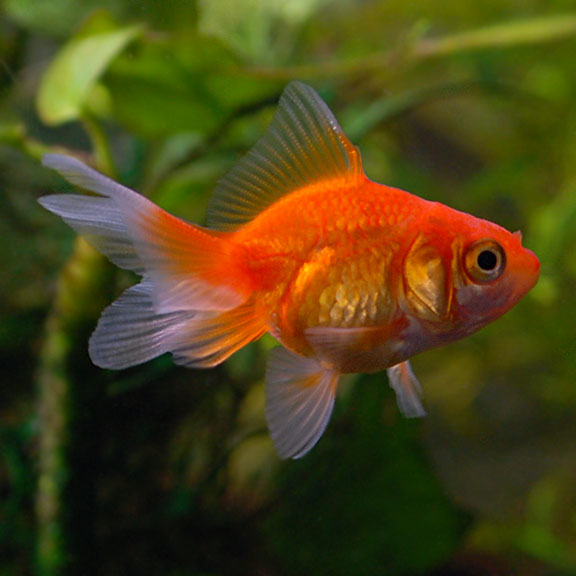

In [45]:
image = PIL.Image.open("goldfish.jpg")
image

In [46]:
image = cv2.imread("goldfish.jpg")

In [47]:
image.shape

(576, 576, 3)

In [48]:
image = cv2.resize(image, (224, 224))

In [49]:
image.shape

(224, 224, 3)

In [50]:
image = image/255

In [51]:
image[np.newaxis, ...].shape

(1, 224, 224, 3)

In [52]:
result = feature_prediction.predict(image[np.newaxis, ...])
print(result)

1/1 [==============================] - 1s 542ms/step
[[ 0.27591828  4.2191305   8.715113   ... -0.34904918 -0.1582432
  -0.83116496]]


In [53]:
y_pred = np.argmax(result)

In [54]:
y_pred

2

In [55]:
labels = []
with open("ImageNetLabels.txt", "r") as f:
    labels = f.read().splitlines()
labels[:5]
    

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [56]:
datasets = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file("flower_photos", origin=datasets,  cache_dir=".",  untar=True)

In [57]:
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('datasets/flower_photos')

In [58]:
image_dataset = {
    "rose" : list(data_dir.glob("roses/*")),
    "daisy" : list(data_dir.glob("daisy/*")),
    "dandelion":list(data_dir.glob("dandelion/*")),
    "sunflower":list(data_dir.glob("sunflowers/*")),
    "tulip":list(data_dir.glob("tulips/*"))
}

image_label = {
    "rose" : 0,
    "daisy" : 1,
    "dandelion":2,
    "sunflower":3,
    "tulip":4
}

X=[]
y=[]
for flower_name, images in image_dataset.items():
    for image in images:
        img = cv2.imread(str(image))
        if img is None:
            print(f"Failed to load image: {image}")
            continue
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(image_label[flower_name])
        
        
    

Failed to load image: datasets\flower_photos\daisy\.ipynb_checkpoints


In [59]:
X = np.array(X)
y = np.array(y)
X = X/255
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape

(2936, 224, 224, 3)

In [60]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [61]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [62]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("First few labels:", y_train[:5])

X_train shape: (2936, 224, 224, 3)
y_train shape: (2936,)
First few labels: [2 3 1 4 0]


In [65]:
model = tf.keras.Sequential([
    pretrained_model_without_top_layer,
    tf.keras.layers.Dense(5)
])

model.compile(optimizer= "adam", 
             loss = "sparse_categorical_crossentropy", 
             metrics = ["accuracy"])

model.fit(X_train, y_train, epochs=10, batch_size=8)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.